In [1]:
import heapq
import math
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.animation as animation
import numpy as np

Dr. Edsger W. Dijkstra came up with Dijkstra's Algorithm in just ten minutes while relaxing in a café. He was simply thinking about the quickest way to get from where he was to his next stop, which led to one of the most important algorithms in computer science.

Dijkstra's Algorithm is a graph search algorithm used to find the shortest path between nodes in a graph.

A graph is determined as a mathematical structure that represents a particular function by connecting a set of points. It is used to create a pairwise relationship between objects. The graph is made up of vertices (nodes) that are connected by the edges (lines).


![Image of Graph](https://mathinsight.org/media/image/image/small_undirected_network_labeled.png)

Lets examine an example. Consider the following graph.

![Image of Graph](https://static.javatpoint.com/tutorial/daa/images/dijkstras-algorithm6.png)


| Node | Visited  | Cost |
|------|----------|------|
| A    | Gaussian | .843 |
| ---  | ---      | ---  |
| B    | Gaussian | .843 |
| ---  | ---      | ---  |
| C    | Gaussian | .843 |
| ---  | ---      | ---  |

In [2]:
%%html
<iframe src="https://www.cs.usfca.edu/~galles/visualization/Dijkstra.html" width="1200" height="1000"></iframe>

In [3]:
class TimeModel:
    """A class representing a model for calculating time-based paths."""

    def __init__(self, start_lat_long, end_lat_long, filename):
        """
        Initializes the TimeModel.

        Parameters:
        - start_lat_long (tuple): Tuple containing start latitude and longitude.
        - end_lat_long (tuple): Tuple containing end latitude and longitude.
        """
        # Read the bathymetry data from a file (specified by sys.argv[1])
        self.lines = self.readlines(filename)

        # Extract grid properties (ncols, nrows, etc.) from the read lines
        self.ncols = int(self.lines[0].split()[0])  # Extract the number of columns
        self.nrows = int(self.lines[1].split()[0])  # Extract the number of rows
        self.xllcorner = float(self.lines[2].split()[0])  # Extract x-coordinate of lower left corner
        self.yllcorner = float(self.lines[3].split()[0])  # Extract y-coordinate of lower left corner
        self.cellsize = float(self.lines[4].split()[0])  # Extract cell size
        # Create a matrix/grid using data starting from line 7
        self.grid = self.make_matrix(self.lines[6:])

        # Generate latitude and longitude grid used to pinpoint specific depths
        self.lat_long_grid = self.generate_lat_long_grid()

        # Find the start and end points based on given latitude and longitude
        self.start_lat_long = start_lat_long
        self.end_lat_long = end_lat_long
        self.start_point = self.find_start_point(start_lat_long)
        self.end_point = self.find_start_point(end_lat_long)


    def make_matrix(self, lines):
        # Converts the bathymetry data into a grid
        matrix = []
        for line in lines:
            line = line.split()
            new_line = [int(num) for num in line]
            matrix.append(new_line)
        return matrix

    def readlines(self, filename):
        # Reads in the bathymetry data
        with open(filename) as file:
            return file.readlines()

    def dijkstras_algorithm(self):
        """
        Implementation of Dijkstra's algorithm to find the shortest path.

        Returns:
        - lat_long_path (list): Shortest path in latitude and longitude coordinates.
        - total_time (float): Total time taken for the shortest path.
        """
        # Calculate the dimensions of the bathymetry grid
        rows = self.nrows
        cols = self.ncols

        # Initialize distance and visited dictionaries
        # distance: Keeps track of the minimum distance to each node
        # visited: Keeps track of the previous node in the path
        distance = {self.start_point: 0}  # Start node has distance 0
        for row in range(rows):
            for col in range(cols):
                if self.grid[row][col] >= 0:
                    # Initialize all other nodes with infinite distance
                    distance[(row, col)] = float('inf')
        visited = {self.start_point: None}  # Start node has no previous node

        # Initialize the priority queue
        queue = [(0, self.start_point)]  # Heap queue sorted by shortest distance
        heapq.heapify(queue)

        while queue:
            # Get the node with the minimum distance from the queue
            current_time, current_node = heapq.heappop(queue)

            # Check if we have reached the end point
            if current_node == self.end_point:
                break

            # Explore the neighbors of the current node
            for neighbor in self.get_neighbors(current_node, rows, cols):
                if self.grid[neighbor[0]][neighbor[1]] >= 0:
                    continue # Skip obstacles or non-traversable nodes(nodes on land)

                # Calculate time required to move from current node to neighbor
                neighbor_depth = self.grid[neighbor[0]][neighbor[1]]
                current_depth = self.grid[current_node[0]][current_node[1]]
                time = 1852.32 / (math.sqrt(((abs(current_depth) + abs(neighbor_depth)) / 2) * 9.8))

                # Calculate the new time for the neighbor through the current node
                new_time = distance[current_node] + time

                # Update if the new time to reach neighbor is shorter
                if neighbor not in distance or new_time < distance[neighbor]:
                    distance[neighbor] = new_time
                    visited[neighbor] = current_node  # Update previous node
                    heapq.heappush(queue, (new_time, neighbor))  # Push updated time and node to queue

        # Reconstruct the path from start to end
        path = []
        current = self.end_point
        while current:
            # path.append(current)
            # current = visited[current]
            try:
                path.append(current)
                current = visited[current]
            except (KeyError, TypeError) as e: # if an error gets thrown here,
                return None, -1                 # that means that the surrounding lat longs are all positive elevation


        path.reverse()  # Reverse to get the path from start to end
        lat_long_path = self.convert_path_to_lat_long(path)
        total_time = distance[self.end_point]  # Total time taken for the shortest path
        return lat_long_path, total_time/60

    def get_neighbors(self, node, rows, cols):
        """
        Retrieves neighboring nodes of a given node within the grid boundaries.

        Parameters:
        - node (tuple): Coordinates of the current node (row, col).
        - rows (int): Total rows in the grid.
        - cols (int): Total columns in the grid.

        Returns:
        - neighbors (list): List of neighboring nodes.
        """
        neighbors = []  # Initialize an empty list to store neighboring nodes
        row, col = node  # Unpack the current node's coordinates

        # Explore adjacent nodes and check grid boundaries
        # Append valid neighboring nodes to the 'neighbors' list
        if row > 0:
            neighbors.append((row - 1, col))  # Upper neighbor
        if row < rows - 1:
            neighbors.append((row + 1, col))  # Lower neighbor
        if col > 0:
            neighbors.append((row, col - 1))  # Left neighbor
        if col < cols - 1:
            neighbors.append((row, col + 1))  # Right neighbor

        return neighbors

    def generate_lat_long_grid(self):
        """
        Generates a grid of latitude and longitude coordinates.

        Returns:
        - grid (list): Grid of latitude and longitude coordinates.
        """
        start_value = (self.xllcorner, self.yllcorner)  # Starting latitude and longitude to line up with the bathymetry data
        increment = self.cellsize
        rows = self.nrows
        columns = self.ncols

        grid = []
        for row in range(rows):
            current_row = []
            for col in range(columns):
                value = (start_value[0] + col * increment, start_value[1] + row * increment)
                current_row.append(value)
            grid.append(current_row)

        return grid[::-1]  # Flipping the grid and returning it

    def find_start_point(self, lat_long_point):
        """
        Finds the closest grid point to a given latitude and longitude point.

        Parameters:
        - lat_long_point (tuple): Latitude and longitude coordinates.

        Returns:
        - closest_position (tuple): Closest grid point coordinates.
        """
        closest_value_diff = float('inf')  # Initialize a variable to track the closest value difference
        closest_position = (0,0) # Initialize a variable to store the closest position

        # Iterate through the grid to find the closest grid point
        for i in range(len(self.lat_long_grid)):
            for j in range(len(self.lat_long_grid[i])):
                current_tuple = self.lat_long_grid[i][j]  # Get current grid point coordinates

                # Calculate the absolute difference between the points
                value_diff = sum(abs(x - y) for x, y in zip(lat_long_point, current_tuple))

                # Check if the current grid point is closer than the previously closest one
                # and self.grid[closest_position[0]][closest_position[1]] < 0
                thing = self.grid[i][j]
                if value_diff < closest_value_diff and thing < 0:
                    #print("Close", thing)
                    closest_value_diff = value_diff  # Update the closest value difference
                    closest_position = (i, j)  # Update the closest position
        #thing = self.grid[closest_position[0]][closest_position[1]]
        return closest_position   # Return the coordinates of the closest grid point

    def convert_path_to_lat_long(self, path):
        """
        Converts a path of grid points to a list of latitude and longitude coordinates.

        Parameters:
        - path (list): List of grid points.

        Returns:
        - lat_long_path (list): List of latitude and longitude coordinates.
        """
        # Convert each grid point in the path to latitude and longitude coordinates
        lat_long_path = [self.lat_long_grid[row][col] for (row, col) in path]
        return lat_long_path

In [4]:
pulu_ai = (129.775,-4.5175)
banda_neira= (129.8965,-4.5248)
buru = (127.113,-3.3815)
hulaliu = (128.557,-3.543)
saparua = (128.657,-3.576)
kulur = (128.562,-3.501)
ameth = (128.807,-3.6455)
amahai = (128.921,-3.338)

In [5]:
start_lat_long = (131.75, -5.52)
#pulu_ai, banda_neira, buru, hulaliu, saparua, kulur, ameth, amahai
end_lat_long = ameth


In [6]:
file_path = r"C:\Users\ashle\Documents\Whitehead Research\Research 2023\1852\etopo.tt3"

time_model_instance = TimeModel(start_lat_long, end_lat_long, file_path)
path, total_time = time_model_instance.dijkstras_algorithm()

print("Time in minutes:", total_time)

Time in minutes: 44.558788484222376


MovieWriter ffmpeg unavailable; using Pillow instead.


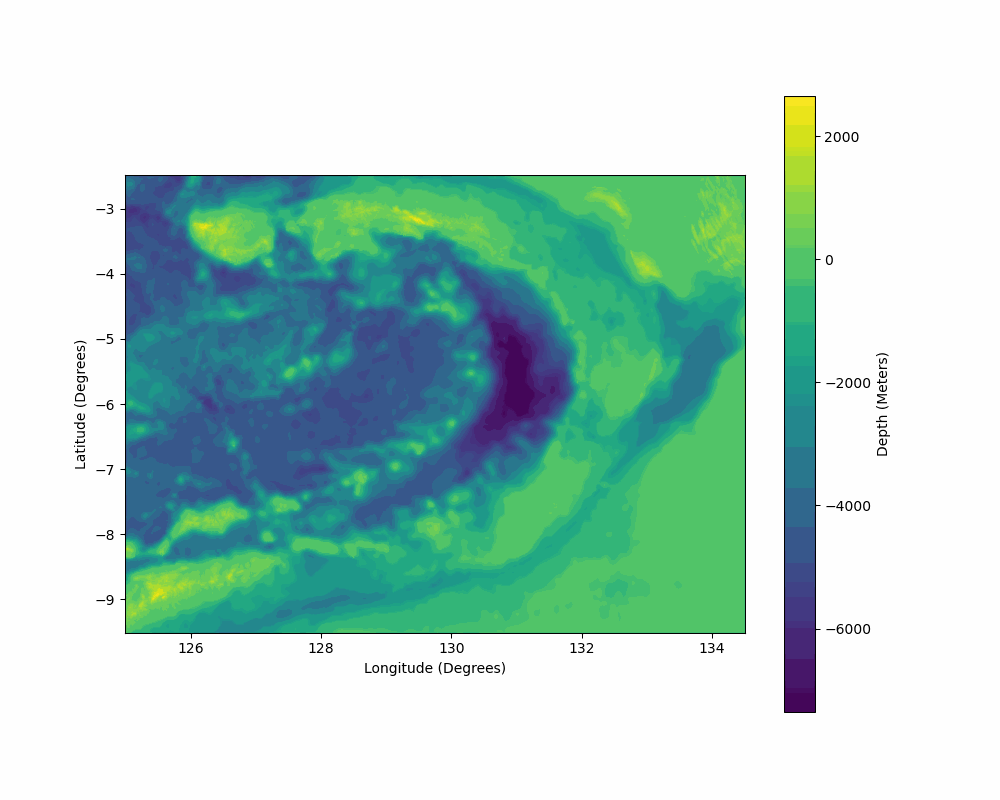

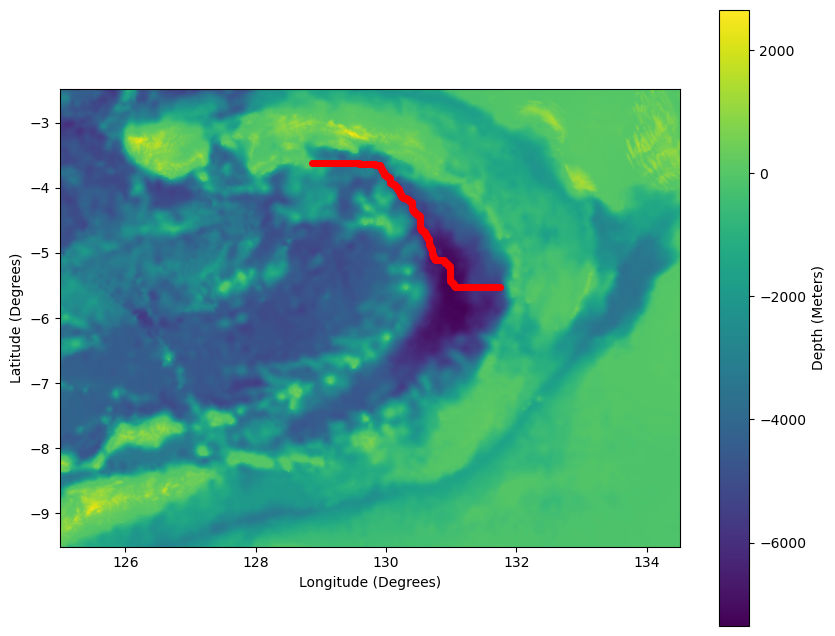

In [7]:
# Read the data from the text file
data = getattr(time_model_instance, "grid")

# Reshape the data into a 2D array (assuming it's a grid)
rows = 421
cols = 571

# Create X and Y coordinates for the grid
xllcorner = 124.991666666667
yllcorner = -9.508333333333
cellsize = 0.016666666667

x = np.arange(xllcorner, xllcorner + cols * cellsize, cellsize)
y = np.arange(yllcorner, yllcorner + rows * cellsize, cellsize)

# # Plot the data using Matplotlib's imshow function
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(data, extent=(xllcorner, xllcorner + cols * cellsize, yllcorner, yllcorner + rows * cellsize), cmap='viridis')
fig.colorbar(cax, label='Depth (Meters)')
  
ax.set_xlabel('Longitude (Degrees)')
ax.set_ylabel('Latitude (Degrees)')

x_coords, y_coords = zip(*path)

multiplier = 3

# Initialize a line object to be updated during the animation
line, = ax.plot([], [], marker='o', linestyle='-', color='red', label='Path', linewidth=1, markersize=4)

# Initialization function for FuncAnimation
def init():
    line.set_data([], [])
    return line,

# Animation function for FuncAnimation
def update(frame):
    line.set_data(x_coords[:frame*multiplier], y_coords[:frame*multiplier])
    return line,


# Create the animation
ani = animation.FuncAnimation(fig, update, frames=int(len(x_coords)/multiplier), init_func=init, blit=True, repeat=False)

# Save the animation as a gif
gif_path = 'tsunami_path_animation.gif'
ani.save(gif_path, fps=30)


display(Image(data=open(gif_path,'rb').read(), format='gif'))

124.991666666667 134.50833333352787 -9.508333333333 -2.5083333331931374


MovieWriter ffmpeg unavailable; using Pillow instead.


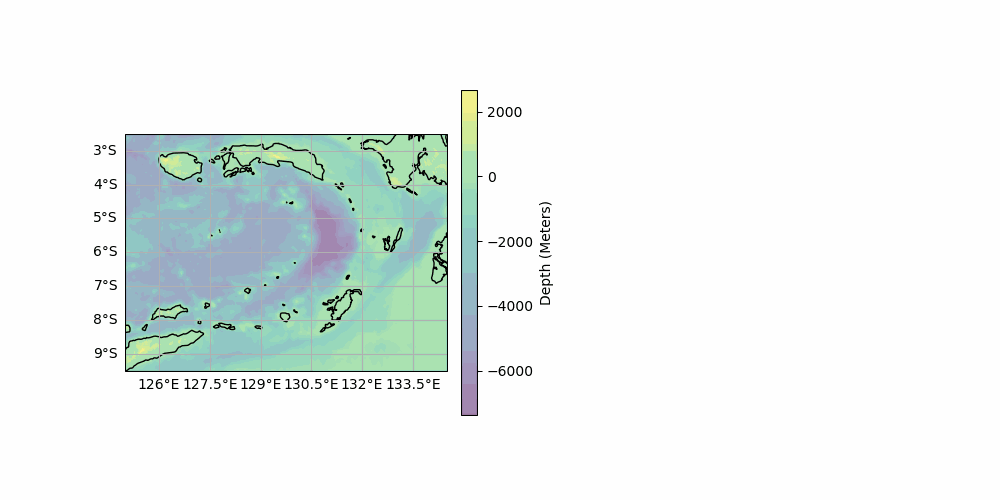

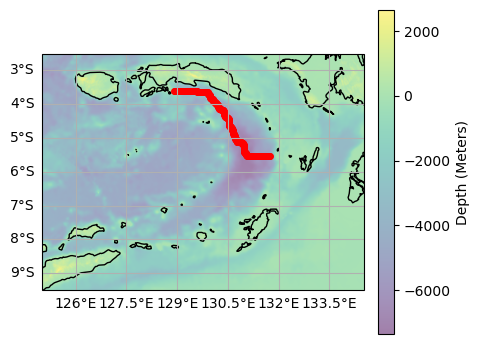

In [8]:
# Create a subplot for the coastlines
fig = plt.figure(figsize=(10, 5))

# Create the main plot with coastlines
ax_coastlines = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())

# Set the extent of the map
ax_coastlines.set_extent((x[0], x[-1], y[0], y[-1]), crs=ccrs.PlateCarree())

print(x[0], x[-1], y[0], y[-1])
# Add coastlines
ax_coastlines.coastlines(resolution='10m')

# Plot the bathymetry data
data = getattr(time_model_instance, "grid")  # Ensure this data is loaded
im = ax_coastlines.imshow(data, extent=(xllcorner, xllcorner + cols * cellsize, yllcorner, yllcorner + rows * cellsize), cmap='viridis', origin='upper', alpha=0.5)
gl = ax_coastlines.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
cbar = plt.colorbar(im, ax=ax_coastlines, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Depth (Meters)')

x_coords, y_coords = zip(*path)

multiplier = 5

# Initialize a line object to be updated during the animation
line, = ax_coastlines.plot([], [], marker='o', linestyle='-', color='red', label='Path', linewidth=1, markersize=4)

# Initialization function for FuncAnimation
def init():
    line.set_data([], [])
    return line,

# Animation function for FuncAnimation
def update(frame):
    line.set_data(x_coords[:frame*multiplier], y_coords[:frame*multiplier])
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=int(len(x_coords)/multiplier), init_func=init, blit=True, repeat=False)

# Save the animation as a video file
gif_path = 'tsunami_path_animation.gif'
ani.save(gif_path, fps=30)

display(Image(data=open(gif_path,'rb').read(), format='gif'))